In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd 
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as seq , Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)

In [2]:
df = pd.read_csv('curated-solubility-dataset.csv')
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [3]:
X_smiles = list(df.SMILES)
Y = np.asarray(df.Solubility)
elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce', 
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al', 
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn', 
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd', 
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

In [4]:
def element_to_onehot(element):
    '''
    input : a dictionay  of elements where keys are int and values are elementse.g. {0:B}
    out : one hot vector
    '''
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])]=1.0
        out.append(v)
    return np.asarray(out)

In [5]:
def val_to_class(val):
    '''conver value to one hot class''' 
    if val < -03.65: # insoluble
        return [1,0,0]
    elif val < -1.69:# slightly soluble
        return[0,1,0]
    else: #soluble
        return[0,0,1]

In [6]:
#create graph from smiles

nodes = []
edge_index = []

for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen= True)
        feature = element_to_onehot(np.asarray(G.nodes(data= 'element'))[:,1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]])
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass


100%|██████████| 9982/9982 [00:03<00:00, 2641.35it/s]


In [7]:
data = list()
#process graphs into torch_geometric Data objects
for i in tqdm(range(0,len(nodes))):
    x = torch.tensor(nodes[i], dtype= torch.float)
    edges = torch.tensor(edge_index[i], dtype = torch.long)
    y = torch.tensor(val_to_class(Y[i]), dtype = torch.float)
    data.append(Data(x=x,edge_index=edges, y = y))
random.shuffle(data)
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]
train = data

100%|██████████| 9947/9947 [00:00<00:00, 54339.73it/s]


In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 3)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        
        x = torch.sum(x, dim=0)
        x = self.lin1(x)
        x = F.relu(x)
        
        x = self.lin2(x)
        return x
        


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)
CSE = CrossEntropyLoss()

In [10]:
model.train()
for epoch in range(2):
    sum_loss = 0
    num_correct = 0
    random.shuffle(train)
    for d in tqdm(train):
        data = d.to(device)
        optimizer.zero_grad()
        out = model(data)
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1
        loss = CSE(torch.reshape(out,[1,3]), torch.reshape(torch.argmax(data.y), [1]))
        sum_loss += float(loss)
        loss.backward()
        optimizer.step()
    print('Epoch: {:03}, Average loss: {:.5f}, Accuracy: {:.5}'.format(epoch,sum_loss/len(train),num_correct/len(train)))


100%|██████████| 9947/9947 [00:08<00:00, 1117.98it/s]


Epoch: 000, Average loss: 1.08007, Accuracy: 0.38816


100%|██████████| 9947/9947 [00:08<00:00, 1117.19it/s]

Epoch: 001, Average loss: 1.06579, Accuracy: 0.4148


100%|██████████| 1990/1990 [00:00<00:00, 2235.42it/s]


Test accuracy: 0.40703517587939697


(array([877., 130., 983.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

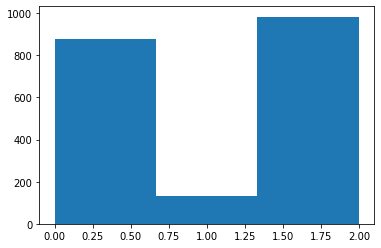

In [11]:
#test the model

num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): 
            num_correct += 1
    predictions.append(torch.argmax(out).item())
    
print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins = 3)

In [12]:
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True)
    feature = element_to_onehot(np.asarray(G.nodes(data= 'element'))[:,1])
    #print(np.asarray(G.nodes(data= 'elements'))[:,1])
    edges = np.asarray(G.edges) 
    index = np.asarray([edges[:,0], edges[:,1]]) 
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) 
    data = d.to(device)
    model.eval() 
    print(classes[torch.argmax(torch.softmax(model(data),dim= 0)).item()])

In [17]:
#c vitamine
evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O')

soluble


In [18]:
#olive oil
evaluate_smiles('CCCCCCCCCCCCCCCCCC(=O)OCC.CCCCCCCCCCCCCCCC(=O)OCC.CCCCCCCCC=CCCCCCCCC(=O)OCC.CCCCCC=CCC=CCCCCCCCC(=O)OCC.CCC=CCC=CCC=CCCCCCCCC(=O)OCC')

insoluble
